# Chemical analysis

## libraries import

In [207]:
import os
import gc
import re
import requests
import time
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats import diagnostic
from scipy import stats

from src.drugbank_XML_drugparser import DrugParser
from src.drugbank_bindingdb_merger import DrugBank_BindingDB_Merger
from src.preprocessing import Preprocessing, ColumnClean

from src.data_paths import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
# loads bindingDB and Drugbank merged
merged_df = pd.read_pickle(MERGED)

In [209]:
# loads cancerous protein dataframe
protein_classes = pd.read_csv("data/clean/protein_class_COSMIC.tsv", sep='\t')

for col in protein_classes.columns:
    print(col)
protein_classes

Gene
Gene synonym
Ensembl
Gene description
Uniprot
Chromosome
Position
Protein class
Biological process
Molecular function
Disease involvement
Evidence
HPA evidence
UniProt evidence
NeXtProt evidence
RNA tissue specificity
RNA tissue distribution
RNA tissue specificity score
RNA tissue specific nTPM
RNA single cell type specificity
RNA single cell type distribution
RNA single cell type specificity score
RNA single cell type specific nTPM
RNA single nuclei brain specificity
RNA single nuclei brain distribution
RNA single nuclei brain specificity score
RNA single nuclei brain specific nTPM
RNA cancer specificity
RNA cancer distribution
RNA cancer specificity score
RNA cancer specific FPKM
RNA brain regional specificity
RNA brain regional distribution
RNA brain regional specificity score
RNA brain regional specific nTPM
RNA blood cell specificity
RNA blood cell distribution
RNA blood cell specificity score
RNA blood cell specific nTPM
RNA blood lineage specificity
RNA blood lineage distri

,Gene,Gene synonym,Ensembl,Gene description,Uniprot,Chromosome,Position,Protein class,Biological process,Molecular function,...,Cancer prognostics - Pancreatic Adenocarcinoma (TCGA),Cancer prognostics - Pancreatic Adenocarcinoma (validation),Cancer prognostics - Prostate Adenocarcinoma (TCGA),Cancer prognostics - Rectum Adenocarcinoma (TCGA),Cancer prognostics - Rectum Adenocarcinoma (validation),Cancer prognostics - Skin Cuteneous Melanoma (TCGA),Cancer prognostics - Stomach Adenocarcinoma (TCGA),Cancer prognostics - Testicular Germ Cell Tumor (TCGA),Cancer prognostics - Thyroid Carcinoma (TCGA),Cancer prognostics - Uterine Corpus Endometrial Carcinoma (TCGA)
0,ABI1,"ABI-1, E3B1, SSH3BP1",ENSG00000136754,Abl interactor 1,Q8IZP0,10,26746593-26861087,"Cancer-related genes, Disease related genes, P...",Host-virus interaction,NaN,...,unprognostic (6.17e-3),unprognostic (9.66e-2),unprognostic (8.60e-2),unprognostic (1.16e-1),unprognostic (3.28e-2),unprognostic (1.01e-1),unprognostic (3.66e-1),unprognostic (1.72e-1),unprognostic (1.03e-1),unprognostic (1.72e-1)
1,ABL1,"ABL, c-ABL, JTK7, p150",ENSG00000097007,"ABL proto-oncogene 1, non-receptor tyrosine ki...",P00519,9,130713043-130887675,"Cancer-related genes, Disease related genes, E...","Apoptosis, Autophagy, Cell adhesion, DNA damag...","DNA-binding, Kinase, Transferase, Tyrosine-pro...",...,unprognostic (6.12e-2),unprognostic (3.31e-2),unprognostic (1.27e-1),unprognostic (2.01e-2),unprognostic (2.18e-1),unprognostic (2.61e-1),unprognostic (8.92e-2),unprognostic (3.15e-1),unprognostic (1.29e-1),unprognostic (1.96e-2)
2,ABL2,"ABLL, ARG",ENSG00000143322,"ABL proto-oncogene 2, non-receptor tyrosine ki...",P42684,1,179099330-179229684,"Cancer-related genes, Enzymes, Predicted intra...",Cell adhesion,"Kinase, Transferase, Tyrosine-protein kinase",...,unprognostic (2.27e-2),unprognostic (1.90e-3),unprognostic (1.86e-1),unprognostic (1.08e-1),unprognostic (7.21e-2),unprognostic (2.24e-1),unprognostic (9.34e-2),unprognostic (1.59e-1),unprognostic (2.71e-2),unprognostic (5.39e-2)
3,ACKR3,"CMKOR1, CXCR7, GPR159, RDC1",ENSG00000144476,Atypical chemokine receptor 3,P25106,2,236567787-236582354,"Cancer-related genes, Disease related genes, G...","Cell adhesion, Host-virus interaction","Developmental protein, G-protein coupled recep...",...,unprognostic (1.48e-3),unprognostic (8.51e-2),unprognostic (3.54e-2),unprognostic (1.21e-1),unprognostic (4.76e-3),unprognostic (1.29e-2),unprognostic (1.95e-4),unprognostic (1.41e-1),unprognostic (1.15e-3),unprognostic (4.99e-2)
4,ACSL3,"ACS3, FACL3, PRO2194",ENSG00000123983,Acyl-CoA synthetase long chain family member 3,O95573,2,222860942-222944639,"Cancer-related genes, Enzymes, Metabolic prote...","Fatty acid metabolism, Lipid metabolism",Ligase,...,unprognostic (7.65e-2),unprognostic (1.24e-1),unprognostic (2.88e-2),unprognostic (3.03e-1),unprognostic (2.64e-2),unprognostic (8.26e-2),unprognostic (9.29e-2),unprognostic (1.77e-1),unprognostic (1.08e-1),unprognostic (2.19e-1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,ZMYM2,"FIM, MYM, RAMP, ZNF198",ENSG00000121741,Zinc finger MYM-type containing 2,Q9UBW7,13,19958677-20091829,"Cancer-related genes, Disease related genes, H...","Transcription, Transcription regulation",NaN,...,unprognostic (3.57e-2),unprognostic (4.85e-1),unprognostic (1.21e-1),unprognostic (4.77e-2),unprognostic (1.74e-1),unprognostic (7.15e-2),unprognostic (2.15e-1),unprognostic (1.08e-1),unprognostic (3.70e-3),unprognostic (1.30e-1)
568,ZNF331,"RITA, ZNF361, ZNF463",ENSG00000130844,Zinc finger protein 331,Q9NQX6,19,53519527-53580269,"Cancer-related genes, Predicted intracellular ...","Transcription, Transcription regulation",DNA-binding,...,unprognostic (1.35e-2),unprognostic (4.71e-2),unprognostic (4.12e-1),unprognostic (2.69e-1),unprognostic (5.47e-3),unprognostic (1.28e-2),unprognostic (1.03e-3),unprognostic (1.42e-1),unprognostic (2.32e-4),unprognostic (3.34e-2)
569,ZNF384,"CAGH1A, C

In [210]:
# Additional proteins 
highly_studied_proteins = [
    'Cytochrome P450 3A4', 
    'Epidermal growth factor receptor', 
    'Proto-oncogene tyrosine-protein kinase Src', 
    'Vascular endothelial growth factor receptor 2', 
    'Adenosine receptor A2a', 'Cytochrome P450 2C9', 
    'Cytochrome P450 1A2', 'Cytochrome P450 2C19', 
    'Cytochrome P450 2D6', 
    'Prostaglandin G/H synthase 1', 
    'Prostaglandin G/H synthase 2'
    ]

In [211]:
# create lists of the relevant columns to identify cancerous proteins
cancer_proteins = list(protein_classes["Gene"].dropna().values)
genes_uniprot = list(protein_classes["Uniprot"].astype(str).dropna().values)

In [212]:
# joins all targeted proteins 
pattern_protein_names = '|'.join(rf"\b{re.escape(term)}\b" for term in cancer_proteins)
pattern_gene_names =  '|'.join(rf"\b{re.escape(term)}\b" for term in genes_uniprot)
pattern_highly_studied =  '|'.join(rf"\b{re.escape(term)}\b" for term in highly_studied_proteins)

#test
#pattern_protein_names

# extract rows based on the columns that contain cancer_keywords 
filtered_df = merged_df[
    #merged_df['drugbank_drug_unii'].str.contains(pattern_protein_names, case=False, na=False) |
    #merged_df['swissprot_target_chain_name'].str.contains(pattern_protein_names, case=False, na=False) |
    #merged_df['swissprot_protein_id'].str.contains(pattern_gene_names, case=False, na=False) |
    #merged_df['drugbank_protein_name'].str.contains(pattern_protein_names, case=False, na=False)|
    #merged_df['target_name'].str.contains(pattern_highly_studied, case=False, na=False)
    merged_df['target_name'].isin(highly_studied_proteins)
]
filtered_df.reset_index(inplace=True)


print(filtered_df.shape)
filtered_df.head()

(103259, 39)


,index,ki,ph,temp,ic50,ec50,kd,kon,koff,doi,...,drugbank_drug_class_superclass,drugbank_drug_synonyms,drugbank_drug_categories,drugbank_drug_patent_approved,drugbank_drug_interaction,Matched_On,drugbank_protein_name,drugbank_protein_general_function,drugbank_protein_specific_function,drugbank_protein_organism
0,142,<NA>,<NA>,<NA>,50000.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3775,<NA>,7.5,20.0,800.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3776,<NA>,7.5,20.0,220.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3777,<NA>,7.5,20.0,160.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3778,<NA>,7.5,20.0,58.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [213]:
prot = filtered_df[filtered_df.target_name == "Prostaglandin G/H synthase 2"]
prot[prot["drugbank_protein_name"].notna()]
prot

,index,ki,ph,temp,ic50,ec50,kd,kon,koff,doi,...,drugbank_drug_class_superclass,drugbank_drug_synonyms,drugbank_drug_categories,drugbank_drug_patent_approved,drugbank_drug_interaction,Matched_On,drugbank_protein_name,drugbank_protein_general_function,drugbank_protein_specific_function,drugbank_protein_organism
3164,40398,<NA>,8.0,37.0,262000.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm701496h,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3192,40426,<NA>,8.0,37.0,2400.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0510474,...,Benzenoids,2-Acetoxybenzenecarboxylic acid|2-Acetoxybenzo...,"Acids, Carbocyclic|Agents causing angioedema|A...",1999-10-26|2000-01-18|2005-08-09|2015-08-11|20...,DB06605|DB01254|DB01586|DB02123|DB02659|DB0269...,chebi_id,NaN,NaN,NaN,NaN
3193,40427,<NA>,8.0,37.0,500.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0510474,...,Phenylpropanoids and polyketides,3-phenyl-4-[4-(methylsulfonyl)phenyl]-2(5H)-fu...,Agents causing hyperkalemia|Agents that produc...,1995-12-12|2000-05-16|1997-11-25,DB01238|DB14185|DB00022|DB01097|DB08880|DB0021...,chebi_id,NaN,NaN,NaN,NaN
3194,40428,<NA>,8.0,37.0,70.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0510474,...,Organoheterocyclic compounds,Celecoxib|Célécoxib|Celecoxibum|p-(5-p-Tolyl-3...,Agents causing hyperkalemia|Agents that produc...,1999-10-26|2002-05-14|1999-10-26|2017-05-30|20...,DB00175|DB00572|DB00693|DB00822|DB00973|DB0116...,chebi_id,NaN,NaN,NaN,NaN
3197,40431,<NA>,<NA>,<NA>,10000.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0510474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103233,2926193,<NA>,<NA>,<NA>,1700.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103236,2926437,<NA>,<NA>,<NA>,11400.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103237,2926438,<NA>,<NA>,<NA>,13700.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103238,2926439,<NA>,<NA>,<NA>,8000.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


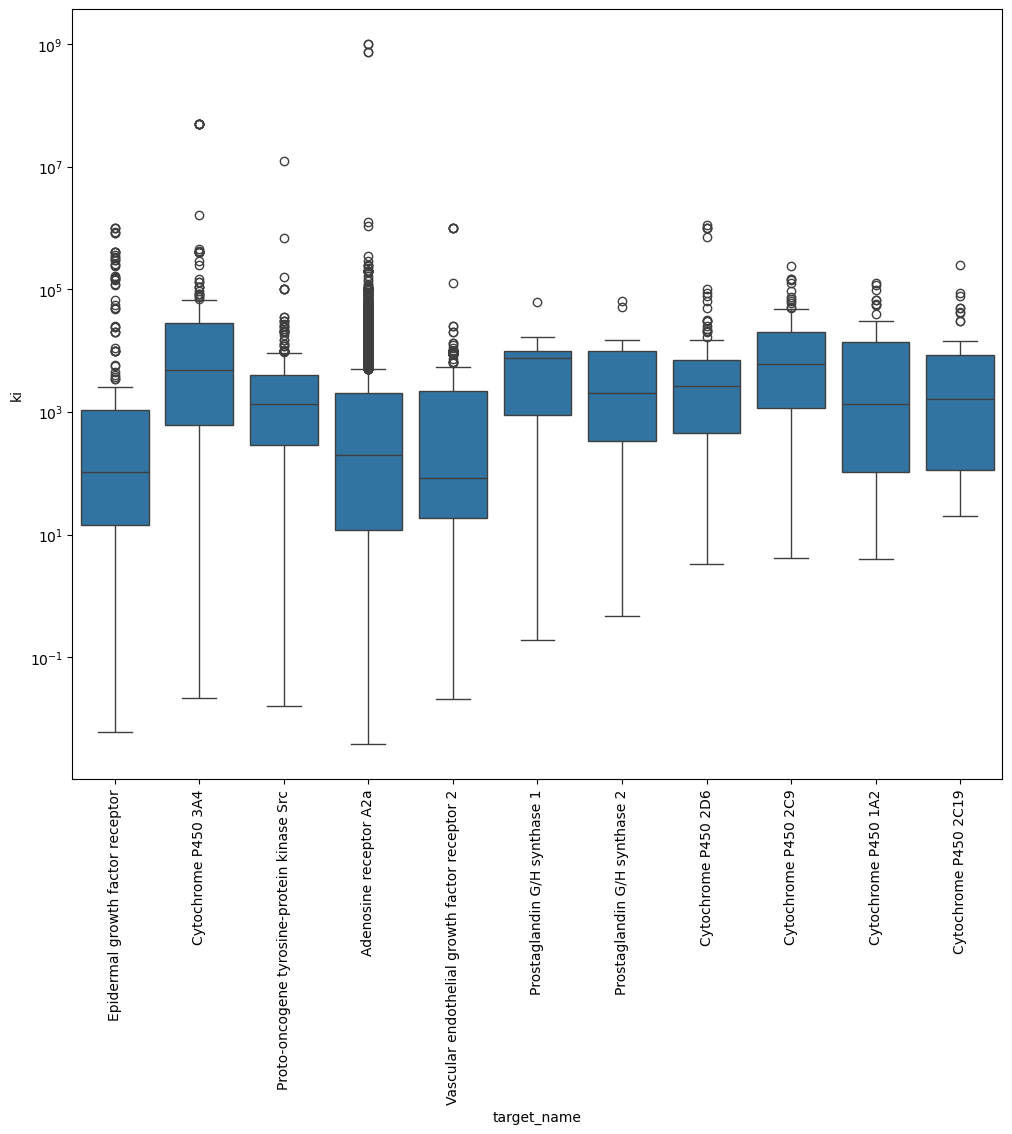

In [214]:
fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(data=filtered_df[filtered_df.ki.isna()==False], x="target_name", y="ki")
plt.yscale("log")
plt.xticks(rotation=90)
plt.show()

C:\Users\godenzi\AppData\Local\Temp\ipykernel_18284\2965862190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['drugbank_drug_name_present'] = filtered_df['drugbank_drug_name'].notna().map({True: 'With DrugBank Drug', False: 'Without DrugBank Drug'})


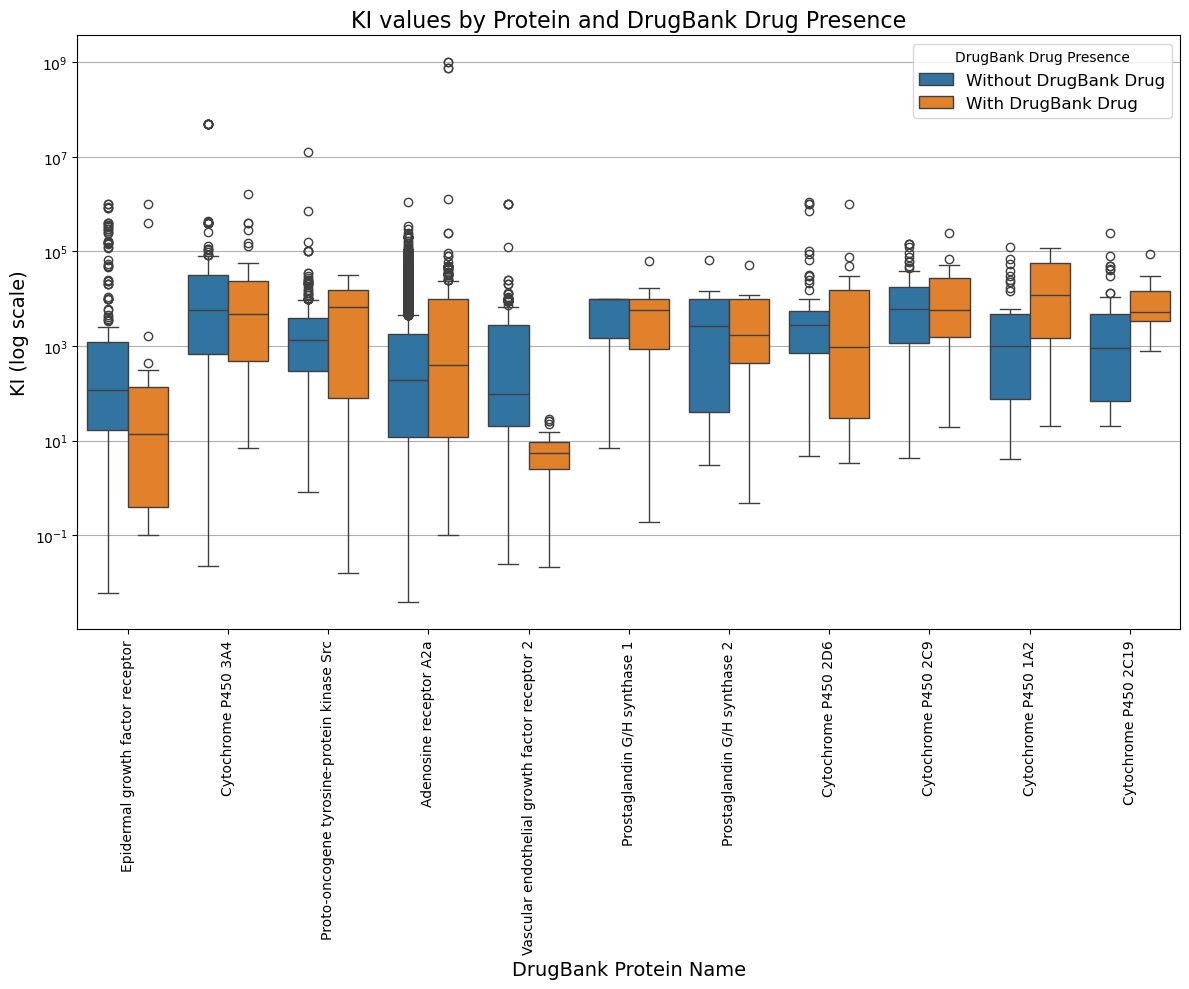

In [215]:
# Create a new column to distinguish rows with and without `drugbank_drug_name`
filtered_df['drugbank_drug_name_present'] = filtered_df['drugbank_drug_name'].notna().map({True: 'With DrugBank Drug', False: 'Without DrugBank Drug'})

# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    data=filtered_df[filtered_df['ki'].notna()],  # Exclude rows with NaN `ki`
    x="target_name",
    y="ki",
    hue="drugbank_drug_name_present"  # Use the new column to separate groups
)
plt.yscale("log")  # Set y-axis to log scale
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("KI values by Protein and DrugBank Drug Presence", fontsize=16)
plt.xlabel("DrugBank Protein Name", fontsize=14)
plt.ylabel("KI (log scale)", fontsize=14)
plt.legend(title="DrugBank Drug Presence", fontsize=12)
plt.tight_layout()
plt.grid(axis="y")
plt.show()


C:\Users\godenzi\AppData\Local\Temp\ipykernel_18284\3815943824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['drugbank_drug_name_present'] = filtered_df['drugbank_drug_name'].notna().map({True: 'With DrugBank Drug', False: 'Without DrugBank Drug'})


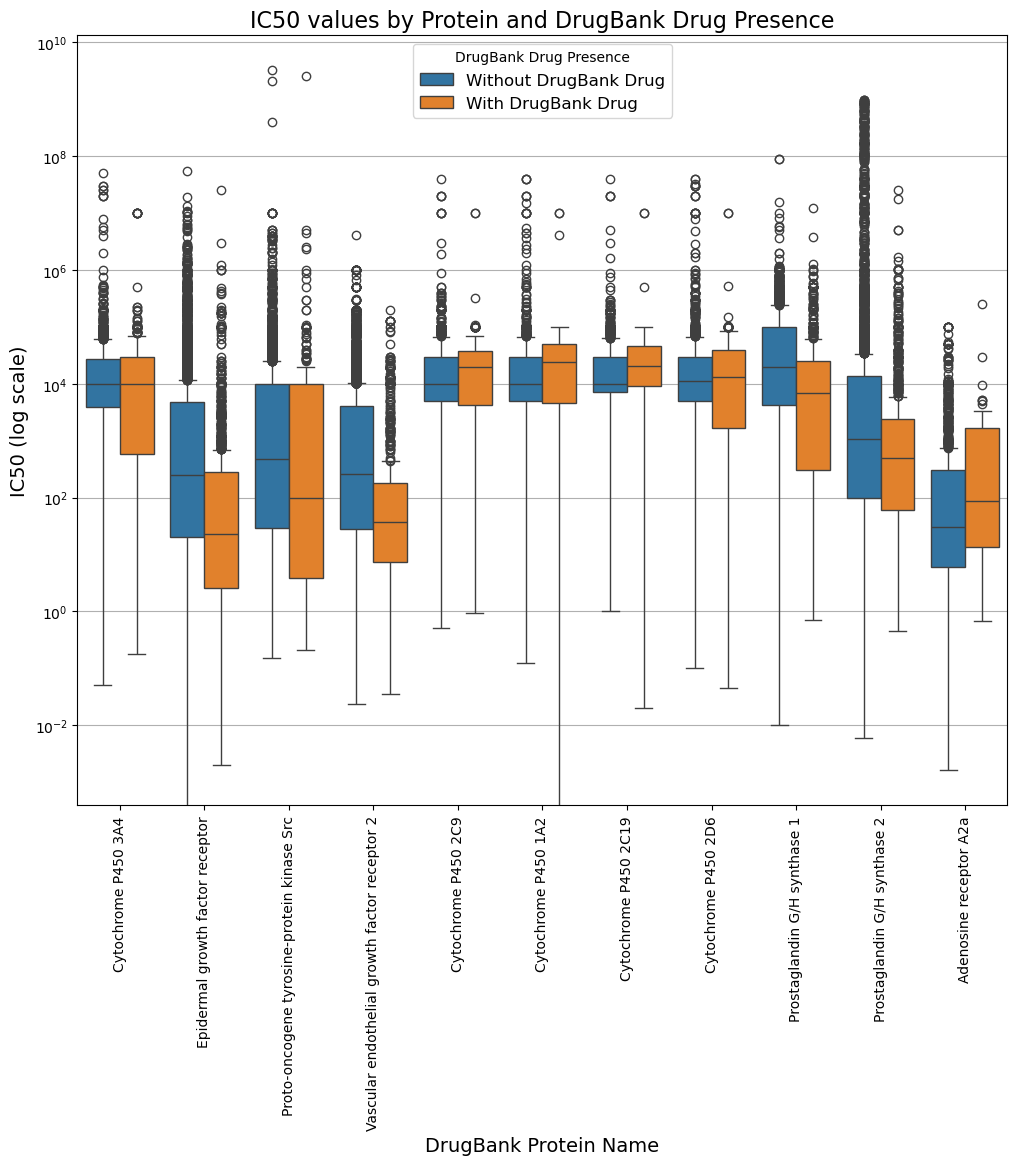

In [216]:
# Create a new column to distinguish rows with and without `drugbank_drug_name`
filtered_df['drugbank_drug_name_present'] = filtered_df['drugbank_drug_name'].notna().map({True: 'With DrugBank Drug', False: 'Without DrugBank Drug'})

# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    data=filtered_df[filtered_df['ic50'].notna()],  # Exclude rows with NaN `ki`
    x="target_name",
    y="ic50",
    hue="drugbank_drug_name_present"  # Use the new column to separate groups
)
plt.yscale("log")  # Set y-axis to log scale
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("IC50 values by Protein and DrugBank Drug Presence", fontsize=16)
plt.xlabel("DrugBank Protein Name", fontsize=14)
plt.ylabel("IC50 (log scale)", fontsize=14)
plt.legend(title="DrugBank Drug Presence", fontsize=12)
#plt.tight_layout()
plt.grid(axis="y")
plt.show()


C:\Users\godenzi\AppData\Local\Temp\ipykernel_18284\3809471827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['drugbank_drug_name_present'] = filtered_df['drugbank_drug_name'].notna().map({True: 'With DrugBank Drug', False: 'Without DrugBank Drug'})


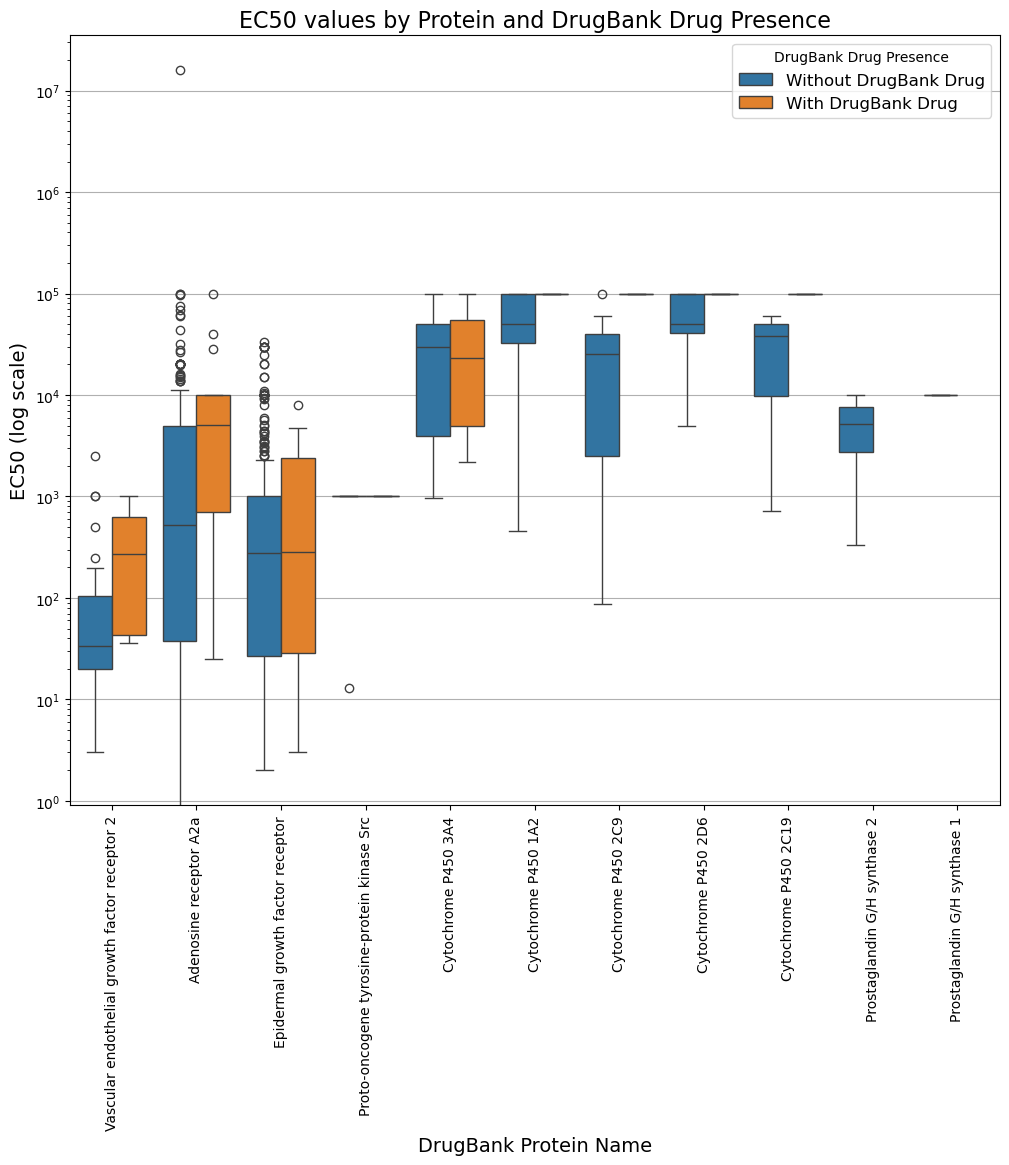

In [238]:
# Create a new column to distinguish rows with and without `drugbank_drug_name`
filtered_df['drugbank_drug_name_present'] = filtered_df['drugbank_drug_name'].notna().map({True: 'With DrugBank Drug', False: 'Without DrugBank Drug'})

# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    data=filtered_df[filtered_df['ec50'].notna()],  # Exclude rows with NaN `ki`
    x="target_name",
    y="ec50",
    hue="drugbank_drug_name_present",  # Use the new column to separate groups
)
plt.yscale("log")  # Set y-axis to log scale
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("EC50 values by Protein and DrugBank Drug Presence", fontsize=16)
plt.xlabel("DrugBank Protein Name", fontsize=14)
plt.ylabel("EC50 (log scale)", fontsize=14)
plt.legend(title="DrugBank Drug Presence", fontsize=12)
#plt.tight_layout()
plt.grid(axis="y")
plt.show()

C:\Users\godenzi\AppData\Local\Temp\ipykernel_18284\691160626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['drugbank_drug_name_present'] = filtered_df['drugbank_drug_name'].notna().map({True: 'With DrugBank Drug', False: 'Without DrugBank Drug'})


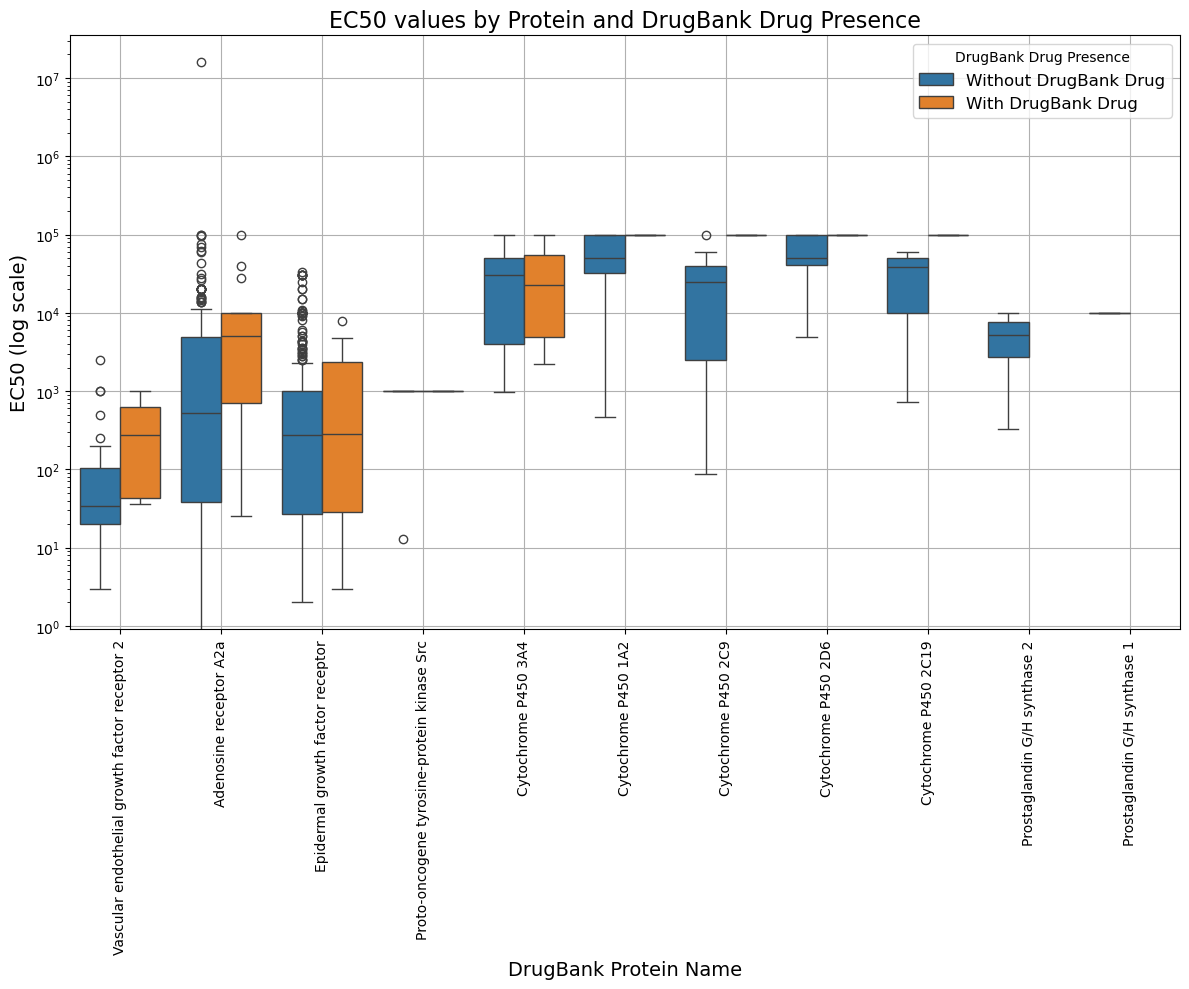

In [239]:
# Create a new column to distinguish rows with and without `drugbank_drug_name`
filtered_df['drugbank_drug_name_present'] = filtered_df['drugbank_drug_name'].notna().map({True: 'With DrugBank Drug', False: 'Without DrugBank Drug'})

# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    data=filtered_df[filtered_df['ec50'].notna()],  # Exclude rows with NaN `ki`
    x="target_name",
    y="ec50",
    hue="drugbank_drug_name_present"  # Use the new column to separate groups
)
plt.yscale("log")  # Set y-axis to log scale
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("EC50 values by Protein and DrugBank Drug Presence", fontsize=16)
plt.xlabel("DrugBank Protein Name", fontsize=14)
plt.ylabel("EC50 (log scale)", fontsize=14)
plt.legend(title="DrugBank Drug Presence", fontsize=12)
plt.tight_layout()
plt.grid("y")
plt.show()

## Overall comparisons 

In [219]:
Drug_df = filtered_df[filtered_df.drugbank_drug_name_present=='With DrugBank Drug']
Drug_df

drug_protein = Drug_df.groupby("target_name")[["ki", "ic50", "ec50"]].median()
drug_protein

,ki,ic50,ec50
target_name,,,
Adenosine receptor A2a,401.0,87.0,5012.0
Cytochrome P450 1A2,12000.0,24400.0,100000.0
Cytochrome P450 2C19,5100.0,20900.0,100000.0
Cytochrome P450 2C9,5800.0,19500.0,100000.0
Cytochrome P450 2D6,960.0,13115.0,100000.0
Cytochrome P450 3A4,4700.0,10000.0,22950.0
Epidermal growth factor receptor,14.0,23.0,286.0
Prostaglandin G/H synthase 1,5700.0,6800.0,<NA>
Prostaglandin G/H synthase 2,1700.0,490.0,<NA>


In [220]:
no_drug_df = filtered_df[filtered_df.drugbank_drug_name_present=="Without DrugBank Drug"]
no_drug_df

no_drug_protein = no_drug_df.groupby("target_name")[["ki", "ic50", "ec50"]].median()
no_drug_protein

,ki,ic50,ec50
target_name,,,
Adenosine receptor A2a,192.0,30.0,529.0
Cytochrome P450 1A2,1010.0,10000.0,50000.0
Cytochrome P450 2C19,925.0,10000.0,38000.0
Cytochrome P450 2C9,6000.0,10000.0,25118.86
Cytochrome P450 2D6,2800.0,11000.0,50000.0
Cytochrome P450 3A4,5745.0,10000.0,30000.0
Epidermal growth factor receptor,117.0,250.0,278.5
Prostaglandin G/H synthase 1,10000.0,20000.0,10000.0
Prostaglandin G/H synthase 2,2600.0,1090.0,5165.0


In [221]:
comparing_drugs_no_drugs = no_drug_protein > drug_protein
comparing_drugs_no_drugs.sum(axis=0)

ki      7
ic50    5
ec50    1
dtype: Int32

## Cancer processes

In [222]:
# joins all targeted proteins 
pattern_protein_names = '|'.join(rf"\b{re.escape(term)}\b" for term in cancer_proteins)
pattern_gene_names =  '|'.join(rf"\b{re.escape(term)}\b" for term in genes_uniprot)
pattern_highly_studied =  '|'.join(rf"\b{re.escape(term)}\b" for term in highly_studied_proteins)

#test
#pattern_protein_names

# extract rows based on the columns that contain cancer_keywords 
all_cancer_molec_df = merged_df[
    #merged_df['drugbank_drug_unii'].str.contains(pattern_protein_names, case=False, na=False) |
    #merged_df['swissprot_target_chain_name'].str.contains(pattern_protein_names, case=False, na=False) |
    merged_df['swissprot_protein_id'].str.contains(pattern_gene_names, case=False, na=False) |
    merged_df['drugbank_protein_name'].str.contains(pattern_protein_names, case=False, na=False)|
    merged_df['target_name'].str.contains(pattern_highly_studied, case=False, na=False)
    #merged_df['target_name'].isin(highly_studied_proteins)
]
all_cancer_molec_df.reset_index(inplace=True)


print(all_cancer_molec_df.shape)
all_cancer_molec_df.head()

(141527, 39)


,index,ki,ph,temp,ic50,ec50,kd,kon,koff,doi,...,drugbank_drug_class_superclass,drugbank_drug_synonyms,drugbank_drug_categories,drugbank_drug_patent_approved,drugbank_drug_interaction,Matched_On,drugbank_protein_name,drugbank_protein_general_function,drugbank_protein_specific_function,drugbank_protein_organism
0,142,<NA>,<NA>,<NA>,50000.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3775,<NA>,7.5,20.0,800.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3776,<NA>,7.5,20.0,220.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3777,<NA>,7.5,20.0,160.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3778,<NA>,7.5,20.0,58.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## merfing dataframes

In [232]:
df = pd.merge(all_cancer_molec_df, protein_classes, left_on ="drugbank_protein_name", right_on="Gene", how="left")
for col in df.columns:
    print(col)

index
ki
ph
temp
ic50
ec50
kd
kon
koff
doi
target_name
ligand_name
pubchem_cid
chebi_id
chembl_id
drugbank_id
kegg_id
zinc_id
smiles
inchi_key
bindingdb_id
swissprot_target_chain_name
swissprot_target_chain_entry_name
swissprot_protein_id
Unique_ID
drugbank_drug_name
drugbank_drug_unii
drugbank_drug_toxicity
drugbank_drug_class_kingdom
drugbank_drug_class_superclass
drugbank_drug_synonyms
drugbank_drug_categories
drugbank_drug_patent_approved
drugbank_drug_interaction
Matched_On
drugbank_protein_name
drugbank_protein_general_function
drugbank_protein_specific_function
drugbank_protein_organism
Gene
Gene synonym
Ensembl
Gene description
Uniprot
Chromosome
Position
Protein class
Biological process
Molecular function
Disease involvement
Evidence
HPA evidence
UniProt evidence
NeXtProt evidence
RNA tissue specificity
RNA tissue distribution
RNA tissue specificity score
RNA tissue specific nTPM
RNA single cell type specificity
RNA single cell type distribution
RNA single cell type specificit

Text(0.5, 1.0, 'mean Ki value for each protein-ligand relationship ')

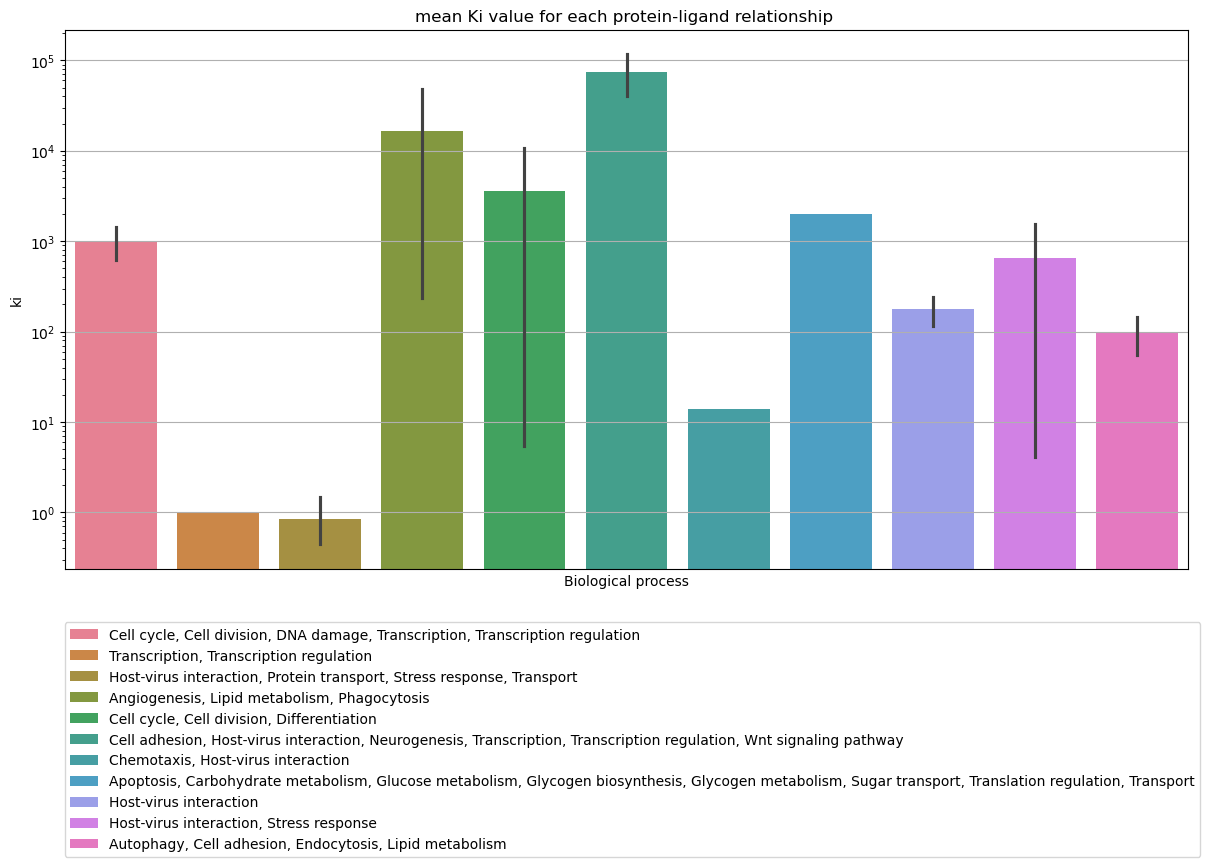

In [233]:
plt.figure(figsize=(14.5,7))
sns.barplot(x="Biological process", y="ki", hue="Biological process", data=df[df.ki.notna()])
plt.xticks(rotation=90)
plt.yscale("log")
# Adjust legend position (outside the plot)
plt.legend(bbox_to_anchor=(0.0, -0.1), loc='upper left', borderaxespad=0.)
plt.xticks([])
plt.grid(axis="y")
plt.title("mean Ki value for each protein-ligand relationship ")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


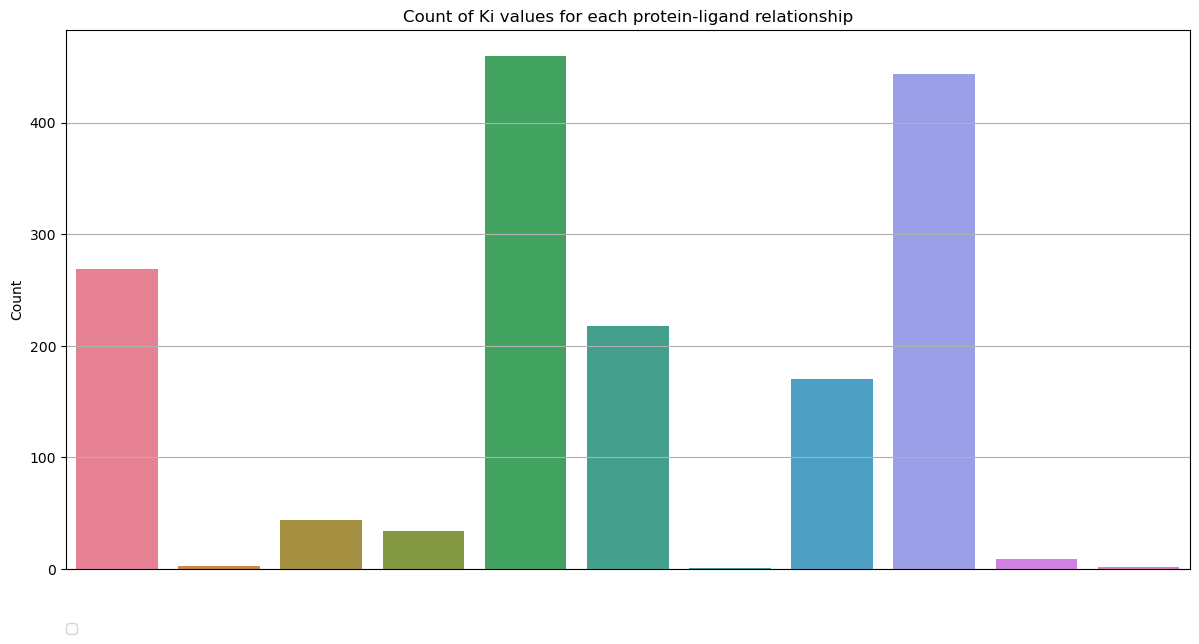

In [234]:
# Aggregate the data to count the number of non-null 'ki' values for each biological process
df_counts = (
    df[df.ki.notna()]
    .groupby("Biological process")
    .size()
    .reset_index(name="count")
)

plt.figure(figsize=(14.5, 7))

# Create the bar plot using counts
sns.barplot(
    x="Biological process",
    y="count",
    hue="Biological process",
    data=df_counts
)

plt.xticks(rotation=90)
# Adjust legend position (outside the plot)
plt.legend(bbox_to_anchor=(0.0, -0.1), loc="upper left", borderaxespad=0.)
plt.xticks([])
plt.grid(axis="y")
plt.title("Count of Ki values for each protein-ligand relationship")
plt.ylabel("Count")
plt.xlabel("")
plt.show()


In [235]:
drug_biological_process = df[df["drugbank_drug_name"].notna()].groupby("Biological process")[["drugbank_drug_name"]].count().reset_index()
drug_biological_process

,Biological process,drugbank_drug_name
0,"Adaptive immunity, Apoptosis, Immunity, Innate...",2
1,"Adaptive immunity, Immunity, Innate immunity",64
2,"Angiogenesis, Differentiation, Host-virus inte...",2
3,"Angiogenesis, Differentiation, Host-virus inte...",16
4,"Angiogenesis, Lipid metabolism, Phagocytosis",65
5,Apoptosis,7
6,"Apoptosis, Autophagy, Cell adhesion, DNA damag...",1
7,"Apoptosis, Biological rhythms, Cell cycle, Hos...",1
8,"Apoptosis, Carbohydrate metabolism, Glucose me...",6
9,"Autophagy, Cell adhesion, Endocytosis, Lipid m...",37


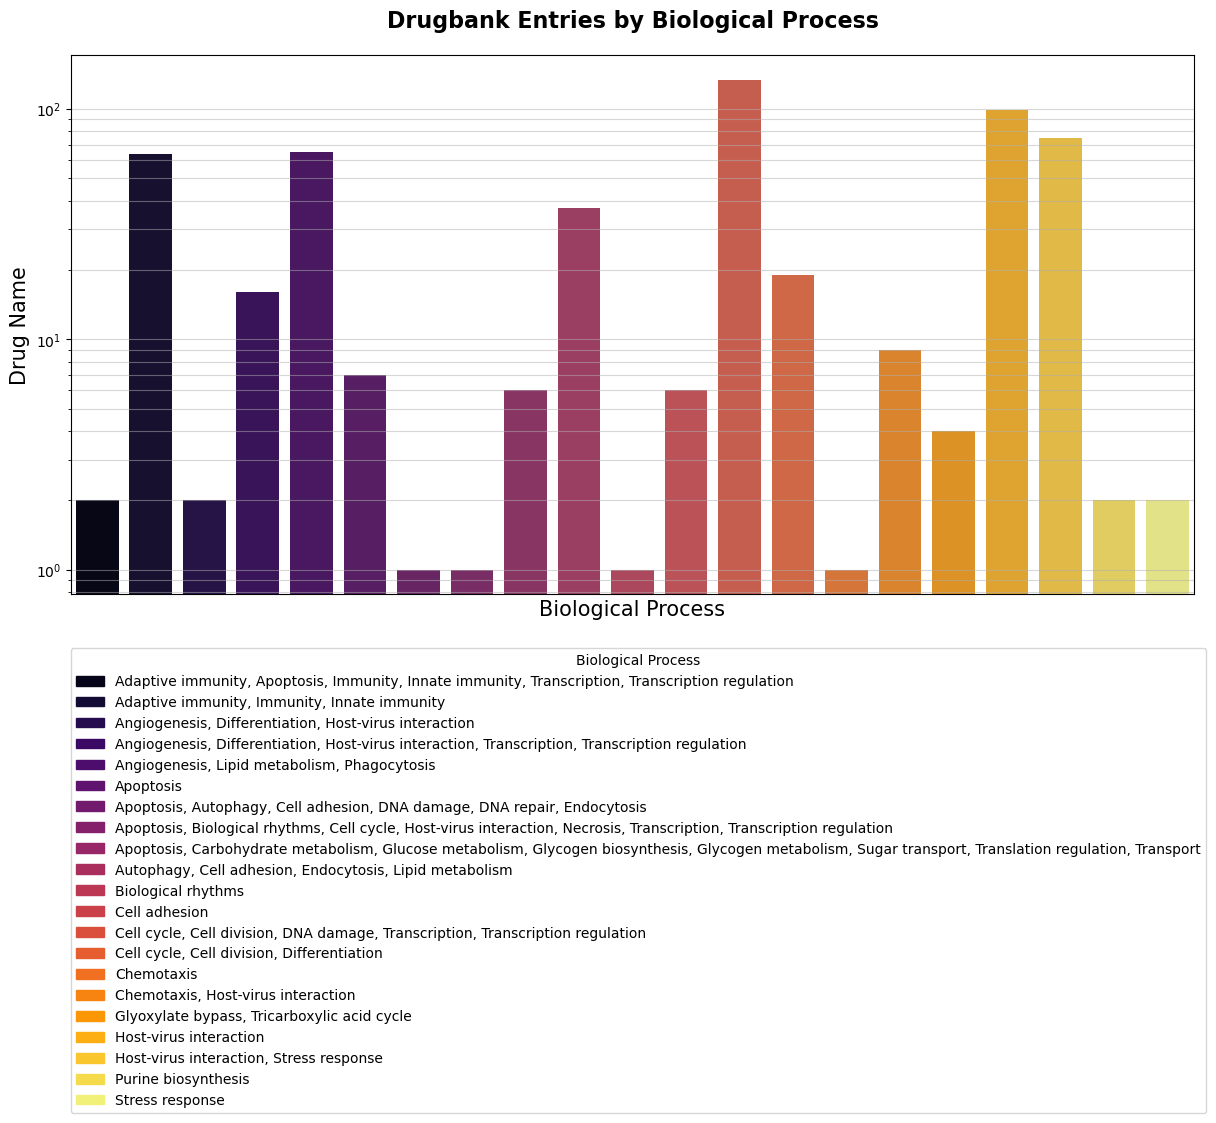

In [236]:
import matplotlib.patches as mpatches

# Set figure size
plt.figure(figsize=(14.5, 7))

# Create the barplot
ax = sns.barplot(
    x="Biological process",
    y="drugbank_drug_name",
    hue="Biological process",
    data=drug_biological_process,
    palette="inferno"
)

# Remove x-tick labels
plt.xticks([])

# Create a custom legend
# Extract unique categories from 'Biological process'
categories = drug_biological_process["Biological process"].unique()
palette = sns.color_palette(n_colors=len(categories), palette="inferno")  # Get the default color palette
legend_handles = [mpatches.Patch(color=palette[i], label=category) for i, category in enumerate(categories)]

# Add the legend with custom colors
plt.legend(
    handles=legend_handles,
    title="Biological Process",
    bbox_to_anchor=(0.0, -0.1), 
    loc='upper left',
    borderaxespad=0.

)

# Customize plot appearance
plt.grid(axis="y", which="both", alpha=0.5)

plt.title(
    "Drugbank Entries by Biological Process",
    fontsize=16,
    fontweight="bold",
    pad=20
)

plt.xlabel("Biological Process", size=15)
plt.ylabel("Drug Name", size=15)
plt.yscale("log")
#plt.tight_layout()

# Show plot
plt.show()


C:\Users\godenzi\AppData\Local\Temp\ipykernel_18284\248398196.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  center_circle = Circle((0, 0), 0.60, color='white', edgecolor='black', linewidth=1.5)


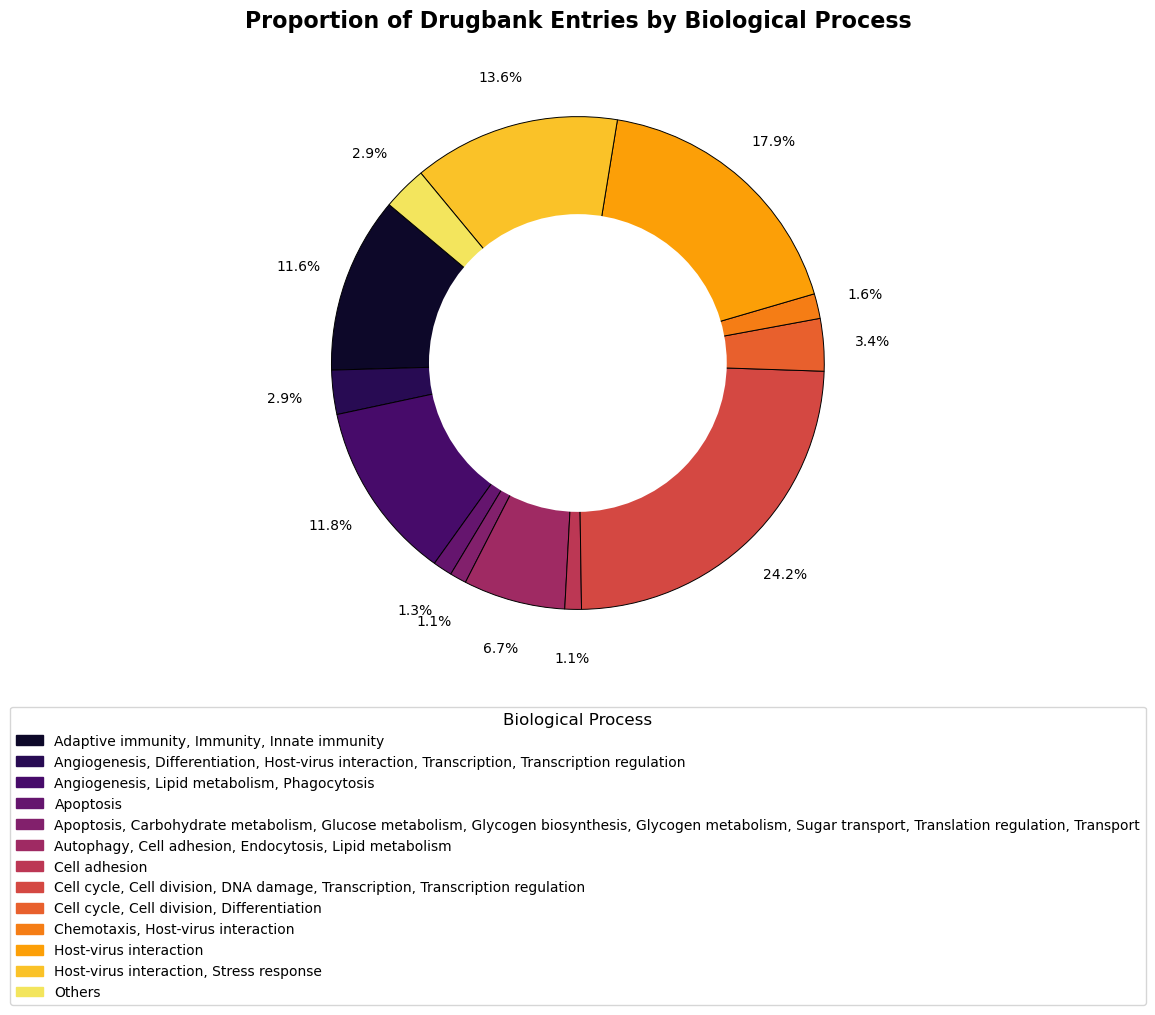

In [237]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

# Extract sizes and categories
sizes = drug_biological_process["drugbank_drug_name"].values
categories = drug_biological_process["Biological process"].values

# Calculate total and percentages
total_size = sum(sizes)
percentages = (sizes / total_size) * 100

# Create a new DataFrame with aggregated "Others"
data = pd.DataFrame({"Biological process": categories, "sizes": sizes, "percentages": percentages})
others = data[data["percentages"] < 1].sum()  # Sum small categories into "Others"
data = data[data["percentages"] >= 1]  # Keep large categories
if not others.empty:
    data = pd.concat([data, pd.DataFrame({"Biological process": ["Others"], "sizes": [others["sizes"]], "percentages": [others["percentages"]]})])

# Generate a color palette for the updated categories
categories = data["Biological process"].values
sizes = data["sizes"].values
palette = sns.color_palette("inferno", n_colors=len(categories))
colors = [palette[i] for i in range(len(categories))]

# Create the pie chart
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=None,  # Remove default labels
    colors=colors,
    autopct='%1.1f%%',  # Percentage values
    startangle=140,
    wedgeprops={"edgecolor": "black", "linewidth": 0.7},
    pctdistance=1.2,  # Position percentages outside the pie
    textprops={'fontsize': 10}
)

# Remove the center to create a donut chart with a black edge
center_circle = Circle((0, 0), 0.60, color='white', edgecolor='black', linewidth=1.5)
plt.gca().add_artist(center_circle)

# Add custom legend below the chart
legend_handles = [mpatches.Patch(color=colors[i], label=categories[i]) for i in range(len(categories))]
plt.legend(
    handles=legend_handles,
    title="Biological Process",
    bbox_to_anchor=(0.5, -0.3),  # Position legend below the chart
    loc='center',
    borderaxespad=0.,
    fontsize=10,
    title_fontsize=12,
    ncol=1  # Arrange legend entries into two columns
)

# Add a visually distinct title
plt.title(
    "Proportion of Drugbank Entries by Biological Process",
    fontsize=16,
    fontweight="bold",
    pad=20
)

# Optimize layout for neatness
#plt.tight_layout()

# Display the chart
plt.show()
